In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras import backend as K

In [5]:
train = pd.read_csv('Train.csv').head(4000)
valid = pd.read_csv('Valid.csv').head(500)

Text(0.5, 1.0, 'Kernel Distribution of Number of words')

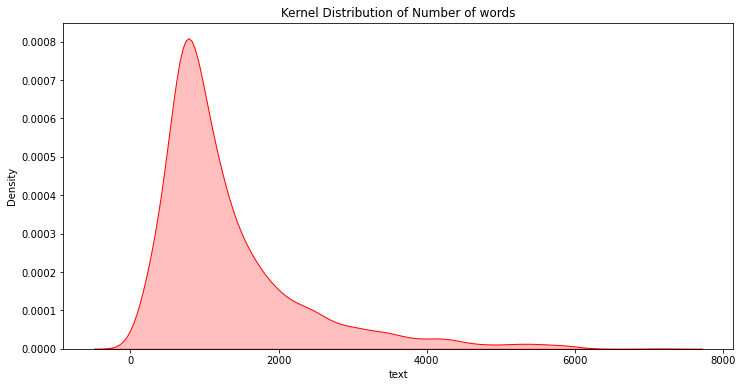

In [6]:
plt.figure(figsize=(12,6))
sns.kdeplot(train['text'].str.lower().str.len(),shade=True,color='r').set_title('Kernel Distribution of Number of words')

In [7]:
import string

exclude = set(string.punctuation) 

def rm_punctualtion(x): 
    try: 
        x = ''.join(ch for ch in x if ch not in exclude) 
    except: 
        pass 
    return x 


train['text'] = train['text'].apply(rm_punctualtion).str.lower()
valid['text'] = valid['text'].apply(rm_punctualtion).str.lower()

In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

def rm_stop_words(x):
    return ' '.join([word for word in x.split() if word not in (stop)])

train['text'] = train['text'].apply(rm_stop_words)
valid['text'] = valid['text'].apply(rm_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mikhail\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### TfIdf

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 20000,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(train['text'])
valid_vectors = vectorizer.transform(valid['text'])

In [10]:
type(train_vectors.toarray())

numpy.ndarray

In [11]:

def get_model():
    inputs = keras.Input(shape=(train_vectors.shape[1],))
    layer1 = layers.Dense(32, activation = "relu")(inputs)
    layer2 = layers.Dropout(0.5)(layer1)
    layer3 = layers.Dense(1,activation = "sigmoid")(layer2)
    model = keras.Model(inputs = inputs, outputs = layer3)
    model.compile(optimizer= "adam", loss= 'binary_crossentropy' ,metrics = ["accuracy"])
    return model

In [12]:
get_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 32)                640032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 640,065
Trainable params: 640,065
Non-trainable params: 0
_________________________________________________________________


In [13]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]
model = get_model()
history = model.fit(
    train_vectors.toarray(), train['label'], 
    epochs=10, 
    verbose=1,
    callbacks = callbacks_list,
    validation_data=(valid_vectors.toarray(), valid['label']))

Epoch 1/10
113/125 [==========================>...] - ETA: 0s - loss: 0.6525 - accuracy: 0.6845
Epoch 00001: val_loss improved from inf to 0.57953, saving model to model.h5
125/125 [==============================] - 11s 12ms/step - loss: 0.6459 - accuracy: 0.6992 - val_loss: 0.5795 - val_accuracy: 0.8220
Epoch 2/10
119/125 [===========================>..] - ETA: 0s - loss: 0.4622 - accuracy: 0.8997
Epoch 00002: val_loss improved from 0.57953 to 0.44571, saving model to model.h5
125/125 [==============================] - 1s 5ms/step - loss: 0.4594 - accuracy: 0.8997 - val_loss: 0.4457 - val_accuracy: 0.8540
Epoch 3/10
117/125 [===========================>..] - ETA: 0s - loss: 0.3001 - accuracy: 0.9412
Epoch 00003: val_loss improved from 0.44571 to 0.37027, saving model to model.h5
125/125 [==============================] - 1s 5ms/step - loss: 0.2984 - accuracy: 0.9420 - val_loss: 0.3703 - val_accuracy: 0.8600
Epoch 4/10
122/125 [============================>.] - ETA: 0s - loss: 0.2009 -

In [14]:

def print_graph():
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

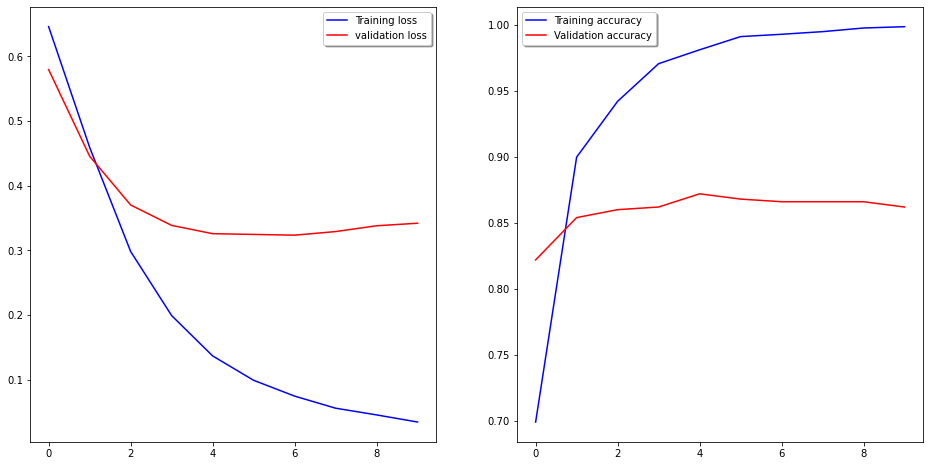

In [15]:
print_graph()

Validation loss уже не падает, как и не растет точность модели на валидации, в целом, ответ лучше, чем статистически предсказывать. В этом методе, если я не ошибаюсь, мы считаем частоту встречания слова ии нверсию частоты, с которой некоторое слово встречается в документах коллекции.

### WordToVec

In [2]:
train = pd.read_csv('Train.csv').head(4000)
valid = pd.read_csv('Valid.csv').head(500)

In [3]:
from gensim.utils import simple_preprocess
def simple_preprocess_(data):
    data['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in data['text']]
simple_preprocess_(train)
simple_preprocess_(valid)
train.head(5)

,text,label,tokenized_text
0,I grew up (b. 1965) watching and loving the Th...,0,"[grew, up, watching, and, loving, the, thunder..."
1,"When I put this movie in my DVD player, and sa...",0,"[when, put, this, movie, in, my, dvd, player, ..."
2,Why do people who do not know what a particula...,0,"[why, do, people, who, do, not, know, what, pa..."
3,Even though I have great interest in Biblical ...,0,"[even, though, have, great, interest, in, bibl..."
4,Im a die hard Dads Army fan and nothing will e...,1,"[im, die, hard, dads, army, fan, and, nothing,..."


In [4]:
from gensim.parsing.porter import PorterStemmer
def stemm_tokens(data):
    porter_stemmer = PorterStemmer()
    data['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in data['tokenized_text']]
stemm_tokens(train)
stemm_tokens(valid)
train.head(5)

,text,label,tokenized_text,stemmed_tokens
0,I grew up (b. 1965) watching and loving the Th...,0,"[grew, up, watching, and, loving, the, thunder...","[grew, up, watch, and, love, the, thunderbird,..."
1,"When I put this movie in my DVD player, and sa...",0,"[when, put, this, movie, in, my, dvd, player, ...","[when, put, thi, movi, in, my, dvd, player, an..."
2,Why do people who do not know what a particula...,0,"[why, do, people, who, do, not, know, what, pa...","[why, do, peopl, who, do, not, know, what, par..."
3,Even though I have great interest in Biblical ...,0,"[even, though, have, great, interest, in, bibl...","[even, though, have, great, interest, in, bibl..."
4,Im a die hard Dads Army fan and nothing will e...,1,"[im, die, hard, dads, army, fan, and, nothing,...","[im, die, hard, dad, armi, fan, and, noth, wil..."


Объединим все предложения и добавим падинг

In [5]:
from gensim.models import Word2Vec
w2v_size = 32
samples = list(pd.concat([train['stemmed_tokens'], valid['stemmed_tokens']], ignore_index=True).values)
for i in range(10):
    samples.append(['pad'])
w2vm = Word2Vec(samples, iter=15, min_count=10, size=w2v_size, workers=4)

In [6]:
'pad' not in w2vm.wv.vocab

False

In [7]:
max_len = pd.concat([train['stemmed_tokens'], valid['stemmed_tokens']], ignore_index=True).map(len).max()
def make_matrix(row):
    arr = np.zeros((max_len, w2v_size), dtype='float32')
    arr[:] = w2vm.wv['pad']
    for i, x in enumerate(row):
        if x not in w2vm.wv.vocab:
            arr[i] = w2vm.wv['pad']
        else:
            arr[i] = w2vm.wv[x]
    return arr

In [8]:
import sys
new_path = r'.\pytorch-fitmodule'
sys.path.append(new_path)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_fitmodule import FitModule
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class NLPConv(FitModule):
    def __init__(self, emb_size, window_sizes=(1, 2, 3, 4, 5)):
        super(NLPConv, self).__init__()
        self.convs = nn.ModuleList([
           nn.Conv2d(1, 32, [window_size, emb_size], padding=(window_size - 1, 0))
           for window_size in window_sizes
        ])
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(emb_size * len(window_sizes), 1)
        self.sig = nn.Sigmoid()
    def forward(self, x):
        #out = self.layer1(x)
        xs = []
        for conv in self.convs:
            x2 = torch.relu(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)
        out = x.reshape(x.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        return self.sig(out).reshape(out.size(0))

f = NLPConv(w2v_size)
f.to(device)
def accuracy(y_true, y_pred):
    return (y_true == y_pred.round()).sum() / y_true.size(0)
train_vector = torch.from_numpy(np.array(list(train['stemmed_tokens'].apply(make_matrix)))).view(4000, 1, max_len, w2v_size).to(device)
train_target = torch.from_numpy(np.array(train['label'], dtype='float32')).to(device)
valid_vector = torch.from_numpy(np.array(list(valid['stemmed_tokens'].apply(make_matrix)))).view(500, 1, max_len, w2v_size).to(device)
valid_target = torch.from_numpy(np.array(valid['label'], dtype='float32')).to(device)
history = f.fit(train_vector, train_target, epochs=20, loss=nn.BCELoss(), validation_data=(valid_vector, valid_target), metrics=[accuracy])

Epoch 1 / 20
[========================================] 100%	loss: 0.7966loss: 0.7966    accuracy: 0.4898    val_loss: 0.6895    val_accuracy: 0.5240

Epoch 2 / 20
[========================================] 100%	loss: 0.6822loss: 0.6822    accuracy: 0.5705    val_loss: 0.6729    val_accuracy: 0.5500

Epoch 3 / 20
[========================================] 100%	loss: 0.6486loss: 0.6486    accuracy: 0.6968    val_loss: 0.6240    val_accuracy: 0.6960

Epoch 4 / 20
[========================================] 100%	loss: 0.6209loss: 0.6209    accuracy: 0.7345    val_loss: 0.5879    val_accuracy: 0.7180

Epoch 5 / 20
[========================================] 100%	loss: 0.5655loss: 0.5655    accuracy: 0.7503    val_loss: 0.5494    val_accuracy: 0.7420

Epoch 6 / 20
[========================================] 100%	loss: 0.5399loss: 0.5399    accuracy: 0.7440    val_loss: 0.5264    val_accuracy: 0.7500

Epoch 7 / 20
[========================================] 100%	loss: 0.5157loss: 0.5157    accur

In [11]:
from collections import defaultdict
def print_graph(data):
    columns = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
    history = defaultdict(list)
    for x in data:
        for col in columns:
            history[col].append(x[col])
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].plot(history['loss'], color='b', label="Training loss")
    ax[0].plot(history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

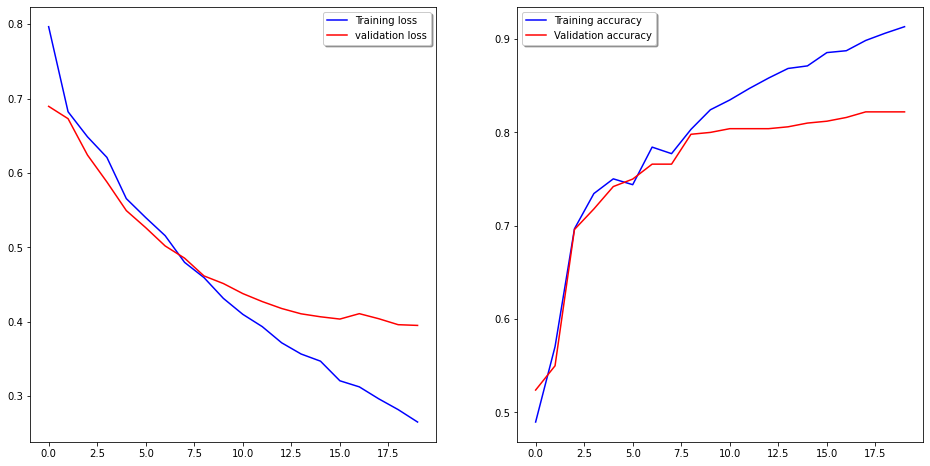

In [12]:
print_graph(history)

Охх, ну и намучился. Сначала написал такую же сетку на tensorflow, но у меня умирал kernel, решил написать на pytorch, но намучился с левой библиотекой (pytorch_fitmodule), скорее всего просто выкачать и запустить у человека не получится, потому что я в ней исправил 10 ошибок где-то. А в итоге сеть более заметно улучшается, но не лучше, чем с методом TfIdf. Тут я использовал эмбединги, обучил их сам и сверточную сеть, в которой сворачивал все эмбединги и по несколько слов из предложения.